## **Week 5: Building our CNN**
### José Manuel López, Alex Martín, Marcos V. Conde

In [1]:
import tensorflow as tf
import pandas as pd
import warnings
import os
import numpy as np
import gc
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

plt.style.use('ggplot')

Loading Data and TF/Keras GPU setup

In [2]:
DATA_DIR_SMALL = "./datasets/MIT_small_train_{}"
DATA_DIR_BIG = "./datasets/MIT_split"
IMG_SIZE = 64
BATCH_SIZE = 128
RANDOM_SEED = 42
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

In [3]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # print model to see if it's compatible with Mixed Precision
    print(device_lib.list_local_devices()[1].physical_device_desc)
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:26:00.0, compute capability: 8.6
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.6.0


In [4]:
def get_dataset(path, aug):
    print("Loading: {}".format(path))
    if not aug:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader
        
    else:

        train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center = False, samplewise_center = False,
                                           featurewise_std_normalization = False, samplewise_std_normalization = False,
                                           rotation_range = 0.2, width_shift_range = 15, height_shift_range = 15, shear_range = 0.2,
                                           zoom_range = 0.2, fill_mode = "nearest", horizontal_flip = True
                                            )
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader



In [5]:
train_small, test_small = get_dataset(DATA_DIR_SMALL.format(1), aug = True)
train_big, test_big = get_dataset(DATA_DIR_BIG, aug = True)


examples = enumerate(train_big)
batch_idx, (example_data, example_targets) = next(examples)
print("Data Shape: {}".format(example_data.shape))

Loading: ./datasets/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Loading: ./datasets/MIT_split
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Data Shape: (128, 64, 64, 3)


Building Model and Plotting Results

In [6]:
def build_model(n_conv = 4, kernel_size = 5, conv = 256, n_dense = 2, dense = 1024, max_pool = False, dropout = False, batch_norm = False, opt = "adam"):
    #create model
    model = Sequential()
    #add model layers
    for idx, i in enumerate(range(n_conv)):
        if idx == 0:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
            
            if max_pool:
                model.add(MaxPooling2D())
        else:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu"))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    for i in range(n_dense):
        model.add(Dense(dense, activation="relu"))
        if dropout:
            model.add(Dropout(0.2))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(len(CLASSES), activation="softmax"))

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

    return model



def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

In [7]:
experiment = []
results = {"Train Loss": [], "Train Accuracy": [],"Test Loss": [],"Test Accuracy": [], "Ratio": [], "Num. Params": []}

## Checking Convolutional Layers

#### 1 Convolution Layer

In [8]:
N_CONV  = 1
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
idx = 0
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [9]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
experiment.append(title)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.6135  Train Loss: 1.0758
Test Accuracy: 0.6555  Test Loss: 1.0011


#### 2 Convolution Layer

In [10]:
N_CONV  = 2
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
idx = 1
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [11]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.7363  Train Loss: 0.7412
Test Accuracy: 0.7745  Test Loss: 0.6835


#### 4 Convolution Layer

In [12]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
idx = 2
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [13]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8570  Train Loss: 0.4197
Test Accuracy: 0.8501  Test Loss: 0.4943


#### 8 Convolution Layer

In [14]:
N_CONV  = 8
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
idx = 3
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [15]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8671  Train Loss: 0.3864
Test Accuracy: 0.8426  Test Loss: 0.4908


## Checking Dense Layers

#### 2 Dense Layer

In [16]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 2
DENSE = 1024
idx = 4
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [17]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8974  Train Loss: 0.3033
Test Accuracy: 0.8538  Test Loss: 0.4606


#### 4 Dense Layer

In [18]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 4
DENSE = 1024
idx = 5
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [19]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8979  Train Loss: 0.3059
Test Accuracy: 0.8686  Test Loss: 0.4426


## Checking Number of Filters

#### 32 Filters

In [20]:
N_CONV  = 4
CONV = 32
KERNEL = 5
N_DENSE = 2
DENSE = 1024
idx = 6
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [21]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8623  Train Loss: 0.4084
Test Accuracy: 0.8439  Test Loss: 0.5130


#### 128 Filters

In [22]:
N_CONV  = 4
CONV = 128
KERNEL = 5
N_DENSE = 2
DENSE = 1024
idx = 7
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [23]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8830  Train Loss: 0.3153
Test Accuracy: 0.8625  Test Loss: 0.4074


#### 256 Filters

In [24]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
idx = 8
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [25]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8703  Train Loss: 0.3822
Test Accuracy: 0.8463  Test Loss: 0.4777


## Checking Regularization

#### Adding MaxPooling

In [26]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
idx = 9
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [27]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9203  Train Loss: 0.2234
Test Accuracy: 0.8637  Test Loss: 0.5073


#### Adding Dropout

In [28]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
idx=10
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, dropout = DROPOUT, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [29]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8862  Train Loss: 0.3031
Test Accuracy: 0.8612  Test Loss: 0.4374


#### Adding Batch Normalization

In [30]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
BATCH_NORM = True
idx = 11
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [31]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9872  Train Loss: 0.0613
Test Accuracy: 0.8786  Test Loss: 0.4408


#### Adding MaxPooling and Dropout

In [32]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
DROPOUT = True
idx = 12
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [33]:
model.load_weights(f'model_{idx}.h5')
title = "Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9266  Train Loss: 0.1964
Test Accuracy: 0.8674  Test Loss: 0.4081


#### Adding MaxPooling and Batch Normalization

In [34]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
BATCH_NORM = True
idx = 13
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [35]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9702  Train Loss: 0.1024
Test Accuracy: 0.8872  Test Loss: 0.3982


#### Adding Batch Normalization and Dropout

In [36]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True
idx = 14
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [37]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9224  Train Loss: 0.2266
Test Accuracy: 0.8649  Test Loss: 0.4379


#### Adding Batch Normalization, MaxPooling and Dropout

In [38]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True
MAX_POOLING = True
idx = 15
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [39]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm, MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9601  Train Loss: 0.1276
Test Accuracy: 0.8897  Test Loss: 0.3572


# Checking Kernel Size

#### 3 Kernel Size

In [40]:
N_CONV  = 4
CONV = 256
KERNEL = 3
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False
idx = 16
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [41]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8995  Train Loss: 0.3013
Test Accuracy: 0.8439  Test Loss: 0.5045


#### 7 Kernel Size

In [42]:
N_CONV  = 4
CONV = 256
KERNEL = 7
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False
idx = 17
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [43]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.8299  Train Loss: 0.5042
Test Accuracy: 0.8290  Test Loss: 0.5557


#### 9 Kernel Size

In [44]:
N_CONV  = 4
CONV = 256
KERNEL = 9
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False
idx = 18
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0, callbacks=[checkpoint, lr_reducer])

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [45]:
model.load_weights(f'model_{idx}.h5')
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.7576  Train Loss: 0.6854
Test Accuracy: 0.7633  Test Loss: 0.7265


## Build Model Similar to Literature

In [46]:
def block(conv, n_filters, n_conv):
    for _ in range(n_conv):
        conv = Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(conv)
    
    conv = MaxPooling2D((2,2), strides=(2,2))(conv)
    
    return conv

def build_block_model():
    # Input
    visible = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Features
    layer = block(visible, 64, 2)
    layer = block(layer, 128, 2)
    layer = block(layer, 256, 4)
    
    # Prediction
    x = GlobalAveragePooling2D()(layer)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(len(CLASSES), activation='softmax')(x)
    
    # Final model
    model = Model(inputs=visible, outputs=pred)
    model.compile(optimizer="adam", loss='categorical_crossentropy',metrics=["accuracy"])

    return model

In [47]:
IMG_SIZE = 64
idx = 19
checkpoint = ModelCheckpoint(f'model_{idx}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)

tf.keras.backend.clear_session()
gc.collect()

train_big, test_big = get_dataset(DATA_DIR_BIG, aug = True)
model = build_block_model()
if not f'model_{idx}.h5' in os.listdir("."):
    history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=100, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, callbacks=[checkpoint, lr_reducer])

Loading: ./datasets/MIT_split
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [48]:
model.load_weights(f'model_{idx}.h5')
title = "3 VGGish Blocks with 0.2 Dropout"
if not f'model_{idx}.h5' in os.listdir("."):
    plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
results["Ratio"].append(acc/(model.count_params()/100*1000))
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))
print("Ration: {} ".format(results["Ratio"][-1]))
results["Num. Params"].append(model.count_params())

Train Accuracy: 0.9522  Train Loss: 0.1410
Test Accuracy: 0.8786  Test Loss: 0.4595
Ration: 3.924048433857002e-09 


## Summarizing all the experiments

In [49]:
df = pd.DataFrame.from_dict(results)
df.index = experiment
df["Model"] = ["Model {}".format(i) for i in range(len(experiment))]
df[["Model","Train Accuracy", "Test Accuracy", "Train Loss", "Test Loss", "Num. Params", "Ratio"]]

,Model,Train Accuracy,Test Accuracy,Train Loss,Test Loss,Num. Params,Ratio
1 Conv 64 filters 5 kernel size 1 dense 1024 neurons,Model 0,0.613503,0.655514,1.075764,1.001122,79624,7.705007e-07
2 Conv 64 filters 5 kernel size 1 dense 1024 neurons,Model 1,0.736310,0.774473,0.741201,0.683470,182088,4.043707e-07
4 Conv 64 filters 5 kernel size 1 dense 1024 neurons,Model 2,0.856991,0.850062,0.419730,0.494306,387016,2.214355e-07
8 Conv 64 filters 5 kernel size 1 dense 1024 neurons,Model 3,0.867092,0.842627,0.386379,0.490809,796872,1.088119e-07
4 Conv 64 filters 5 kernel size 2 dense 1024 neurons,Model 4,0.897395,0.853779,0.303307,0.460579,1436616,6.246589e-08
4 Conv 64 filters 5 kernel size 4 dense 1024 neurons,Model 5,0.897927,0.868649,0.305947,0.442636,3535816,2.539517e-08
4 Conv 32 filters 5 kernel size 2 dense 1024 neurons,Model 6,0.862307,0.843866,0.408355,0.513012,1170920,7.364357e-08
4 Conv 128 filters 5 kernel size 2 dense 1024 neurons,Model 7,0.883041,0.862454,0.315263,0.407398,2428808,3.635697e-08
4 Conv 256 filters 5 kernel size 2 dense 1024 neurons,Model 8,0.870282,0.846344,0.382219,0.477707,6256392,1.391028e-08
4 Conv 256 filters 5 kernel size 2 dense 1024 neurons with MaxPooling,Model 9,0.920255,0.863693,0.223434,0.507280,6256392,1.470904e-08


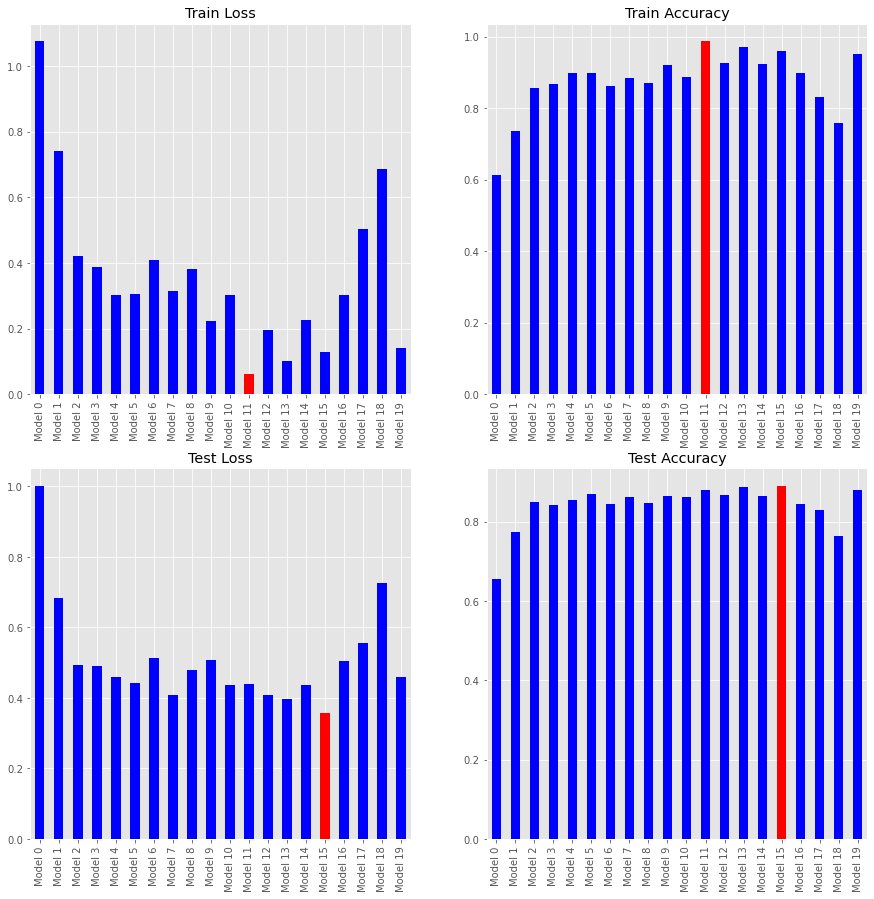

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2)
x = 0
#fig.subplots_adjust(hspace=1)
cols = list(df.columns)
cols.remove("Ratio")
cols.remove("Model")
cols.remove("Num. Params")

for i, col in enumerate(cols):
    c = df[col]
    if "Accuracy" in col:
        colors = ["r" if val == np.max(c) else "b" for val in c]
    else:
        colors = ["r" if val == np.min(c) else "b" for val in c]
        
    if i == 2:
        x = 1
    i = i % 2
            
    c.plot(kind="bar", figsize=(15,15), title=col, ax=axes[x,i], color=colors)
    axes[x,i].set_xticklabels(df["Model"], rotation=90)
plt.show()

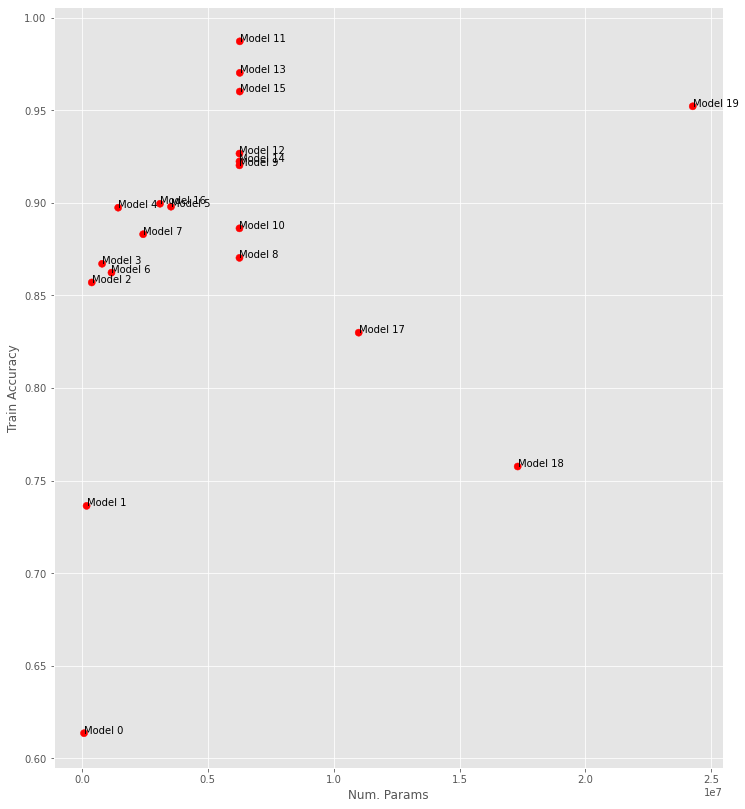

In [51]:
ax = df.plot.scatter(y = "Train Accuracy", x = "Num. Params", figsize=(12,14), color=["r" for _ in range(len(df))], s=50)
for i, j in enumerate(df.index):
    ax.annotate("Model {}".format(i), (df["Num. Params"][i], df["Train Accuracy"][i]))